In [1]:
import numpy as np
import glob
import os
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import correlate
#import stagnation.variables as va
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from natsort import natsorted, ns
import scipy.fft as fft
from scipy.interpolate import griddata 
#from varioustools import graphs

In [2]:
def gaussian(x, sig): #fonction de Gauss utlisé pour la normalisation et le calcul des poids de chaque points
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-1/2*(x/sig)**2)

In [54]:
def expo_decr(x,a,b,cte):
    return np.exp(a*x+b)+cte

In [4]:
L = 120 #box size
dx = 120/2**9 #minimum grid size
print(dx)
folderfig='/home/turbots/Documents/figure/'
eps = 7.8 #mean dissipation without the bubble
rho  = 1 #fluid density (taken as reference)
sig=dx/2

0.234375


In [5]:
folds = glob.glob('Re*') # we pick up all the filme that start with Re and put them in folds
print(len(folds))

286


In [6]:
folds0 = 'Re55t140-l9-16-2540-3-dump_86788'
filesdissint = glob.glob(folds0+ '/localstats_[!f]*')
filesdissext = glob.glob(folds0 + '/localstats_fluid*')
filesinterf = glob.glob(folds0 + '/inter*.dat')
        
    

import warnings

with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
    warnings.simplefilter("ignore") 
    dataint = np.zeros([0, 7], dtype=float)
    dataext = np.zeros([0, 6], dtype=float)
    interf = np.zeros([0, 10], dtype=float)
    bubble = np.zeros([0, 12], dtype=float)
    stat = np.zeros([0, 8], dtype=float)

        


    for file in filesdissint:
        try:
            datatemp = np.loadtxt(file, skiprows=2)
        except:
            datatemp = np.loadtxt(file, skiprows=1)
        if datatemp.shape !=(0,):
            dataint = np.vstack((dataint, datatemp))

    for file in filesinterf:
        datatemp = np.loadtxt(file, skiprows=1)
        if datatemp.shape !=(0,):
            interf = np.vstack((interf, datatemp))

    for file in filesdissext:
        try:
            datatemp = np.loadtxt(file, skiprows=1)
        except:
            datatemp = np.loadtxt(file, skiprows=0)
        if datatemp.shape !=(0,):
            dataext = np.vstack((dataext, datatemp))

try:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=1)
except:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=0)
if datatemp.shape !=(0,):
    bubble = np.vstack((bubble,datatemp))
    
    
try:
    datatemp = np.loadtxt(folds0 +'/stats.dat', skiprows=1)
except:
    datatemp = np.loadtxt(folds0 +'/stats.dat', skiprows=0)
if datatemp.shape !=(0,):
    stat = np.vstack((stat,datatemp))



In [8]:
R0= float(folds0.split('-')[2])
interf_norm=np.sqrt(np.sum(interf[:,7:10]**2,axis=1))
interf[:,7:10]/=interf_norm[:,np.newaxis]


In [9]:
def calculate_orthogonal_vectors(v):
    # Générer un vecteur aléatoire de même dimension que v
    random_vector = np.random.randn(len(v))
    
    # Calculer le produit vectoriel entre v et le vecteur aléatoire
    cross_product = np.cross(v, random_vector)
    
    # Calculer le produit vectoriel entre v et le produit vectoriel précédent
    orthogonal_vector = np.cross(v, cross_product)
    
    # Normaliser les vecteurs
    cross_product_normalized = cross_product / np.linalg.norm(cross_product)
    orthogonal_vector_normalized = orthogonal_vector / np.linalg.norm(orthogonal_vector)
    
    return cross_product_normalized, orthogonal_vector_normalized

In [10]:
#pour chaque normale, on calcule les vecteurs tangentielles correspondant

tangente1,tangente2 = np.zeros([len(interf),3]), np.zeros([len(interf),3])
i=0
for v in interf[:,7:10]:
    tangente1[i,:],tangente2[i,:] = calculate_orthogonal_vectors(v)
    i+=1
    

In [11]:
# on enlève les petites bulles parasites liées à des problèmes de simulations et qui peuvent fausser les résultats

maskint=(dataint[:,0]>-1)
maskinterf=(interf[:,0]>-1)

print(30*dx)
for bulle in bubble:
    if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
        j=bulle[2]
        maskint=np.logical_and(maskint,dataint[:,0][:]!=j)
        maskinterf=np.logical_and(maskinterf,interf[:,0][:]!=j)
#         bubble=np.delete(bubble,(j),axis=0) #on supprime les indices des mauvaises bulles dans bubble
print(dataint[:,0].size,maskint.size) 
# print(bubble[maskbul])
# np.delete(dataint[indicebulle[:],:])  

7.03125
53299 53299


In [12]:
# on calcule approximativement la position du centre de la bulle et on l'utilise pour recentrer les points afin que
#la bulle ne soit pas coupé à travers le domaine. Puis on recalcule le pc (position center)

pc = np.median(dataint[:, 1:4], axis=0)# approximate position center
print(pc)
dataint[:, 1:4] = np.mod(dataint[:, 1:4] - pc + L/2, L) - L/2 #shift data position
dataext[:, 0:3] = np.mod(dataext[:, 0:3] - pc + L/2, L) - L/2 #shift data position
interf[:, 1:4] = np.mod(interf[:, 1:4] - pc + L/2, L) - L/2 #shift interface position

pc = np.mean(dataint[:, 1:4], axis=0)# approximate position center
print(pc)


[ 94.9219 102.891   37.8516]
[ 1.0385688   0.93702944 -0.40353693]


In [13]:
# on masque les points extérieures de la bulle qui sont trop éloigné du centre de la bulle pour réduire le temps 
# de calcul et car on ne s'intéresse qu'a ce qu'il se passe proche de la bulle
maskext=((dataext[:,0]-pc[0])**2+(dataext[:,1]-pc[1])**2+(dataext[:,2]-pc[2])**2<((3.5*R0)**2)) #6*R0



In [14]:
# on crée un masque pour étudier le problème en 1D et en 2D

z = np.mean(dataint[:, 3][maskint])
dz=0.5
y=np.mean(dataint[:, 2][maskint])
dy=0.5

indicez= np.logical_and(dataint[:, 3]>z-dz, dataint[:, 3]<z+dz )
indicey= np.logical_and(dataint[:, 2]>y-dy, dataint[:, 2]<y+dy )
maskint1d=np.logical_and(indicey,indicez)
maskint2d=np.logical_and(indicez,maskint) #masque 2d pour le champ de données intérieures
maskint1d=np.logical_and(maskint1d,maskint) #masque 1d pour le champ de données intérieures

indicez2= np.logical_and(dataext[:, 2]>z-dz, dataext[:, 2]<z+dz )
indicey2= np.logical_and(dataext[:, 1]>y-dy, dataext[:, 1]<y+dy )
maskext2d=np.logical_and(maskext,indicez2)#masque 2d pour le champ de données extérieures
maskext1d=np.logical_and(indicey2,indicez2)#masque 1d pour le champ de données extérieures
maskext1d=np.logical_and(maskext,maskext1d)

indicez3= np.logical_and(interf[:, 3]>z-dz, interf[:, 3]<z+dz )
indicey3= np.logical_and(interf[:, 2]>y-dy, interf[:, 2]<y+dy )
maskinterf2d=np.logical_and(indicez3,maskinterf)
maskinterf1d=np.logical_and(indicez3,indicey3)
maskinterf1d=np.logical_and(maskinterf,maskinterf1d)



In [15]:
voronoi_kdtree = cKDTree(interf[:, 1:4]) #fonction qui trace un diagramme de Voronoi. 
#Ce diagrame permet de crée des régions où sont regorupés tout les points les points proches 
#d'un point de l'interface. Ça permet de calculer la distance des points à l'interface

In [16]:
test_point_dist_ext, test_point_regions_ext = voronoi_kdtree.query(dataext[:, 0:3][maskext])
test_point_dist_int, test_point_regions_int = voronoi_kdtree.query(dataint[:, 1:4][maskint])
#test_point-distance = distance aux point de l'interface != distance qui est la distance à l'interface
# distext_sign=np.sum((dataext[:, 0:3][maskext]-interf[:, 1:4][test_point_regions_ext])*interf[:, 7:10][test_point_regions_ext], axis=1)
# distint_sign=np.sum((dataint[:, 1:4][maskint]-interf[:, 1:4][test_point_regions_int])*interf[:, 7:10][test_point_regions_int], axis=1)

# distance_ext = np.abs(distext_sign)
# distance_int = np.abs(distint_sign)
# print(distance_int.shape)

# positif_int=(distint_sign>=0)
# positif_ext=(distext_sign>=0)


In [17]:
scipy.interpolate.griddata?

Object `scipy.interpolate.griddata` not found.


In [18]:
# grid_x, grid_y,grid_z = np.mgrid[-16:16:100j, -16:16:200j,-0.4:-0.4:1j]
# grid_z0 = griddata((v_norm_in[:,1:4][mask_vit_in_2d]), v_norm_in[:,-2][mask_vit_in_2d] , (grid_x, grid_y, grid_z),method='linear')

In [19]:
# print(len(v_norm_in[mask_vit_in_2d]))
# print(len(vit_in[mask_vit_in_2d]))

# p=plt.imshow(grid_z0, extent=(-16,18,-16,18),origin='lower')
# plt.colorbar(p)

In [21]:
# plt.figure()
# p=plt.scatter(v_norm_in[:,1][mask_vit_in_2d],v_norm_in[:,2][mask_vit_in_2d],c=v_norm_in[:,-2][mask_vit_in_2d],s=1)
# plt.colorbar(p)

In [ ]:
# z0 =40
# grid_x, grid_y,grid_z = np.mgrid[-60:60:100j, -60:60:200j,z0:z0:1j]
# grid_z0 = griddata((v_norm_out[:,0:3][mask_vit_out_2d]), v_norm_out[:,-2][mask_vit_out_2d] , (grid_x, grid_y, grid_z),method='linear')

In [ ]:
# xlim = 60
# p=plt.imshow(grid_z0,origin='lower', extent=(-xlim,xlim,-xlim,xlim))
# plt.colorbar(p)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('norme de vn en dehors de la bulle dans le plan $O_{xy}$' )
# plt.savefig(folderfig + 'champ_vn_out.pdf',bbox_inches='tight')

In [22]:
#test de la normalisation avec une fonction exponentielle
dist = np.linspace(0, 4*R0, 100)

weights = gaussian(test_point_dist_ext -dist[:, np.newaxis], sig)

expo=np.exp(test_point_dist_ext)
print(expo)
mean = np.sum(expo*weights*dataext[:, -1][maskext], axis=1)/np.sum(dataext[:, -1][maskext]*weights, axis=1)
print(mean)

[5.05967172e+12 2.41619813e+12 7.18668135e+12 ... 3.74581457e+12
 1.09306930e+13 5.02773108e+12]
[1.30248257e+00 1.97835732e+00 3.66407601e+00 7.00896934e+00
 1.34236977e+01 2.54611938e+01 4.88542680e+01 9.31760499e+01
 1.77432901e+02 3.37429823e+02 6.51268447e+02 1.23096928e+03
 2.36801307e+03 4.52754100e+03 8.60593818e+03 1.63900842e+04
 3.14667840e+04 5.94862926e+04 1.14250041e+05 2.18258283e+05
 4.16067466e+05 7.91853064e+05 1.51431421e+06 2.88484515e+06
 5.53205710e+06 1.05504243e+07 2.00902883e+07 3.83184901e+07
 7.34623317e+07 1.39238091e+08 2.66587197e+08 5.07636254e+08
 9.74627597e+08 1.84809569e+09 3.54523144e+09 6.74939406e+09
 1.28808387e+10 2.46101477e+10 4.69861516e+10 8.98034766e+10
 1.70850316e+11 3.27304248e+11 6.22557920e+11 1.18905783e+12
 2.26793291e+12 4.33682370e+12 8.27813292e+12 1.58399829e+13
 3.01495766e+13 5.77905717e+13 1.09676631e+14 2.09899696e+14
 3.99616851e+14 7.64333974e+14 1.46229076e+15 2.78013017e+15
 5.32124574e+15 1.01288463e+16 1.93863767e+16 3.6

/tmp/ipykernel_45840/874618440.py:8: RuntimeWarning: invalid value encountered in divide
  mean = np.sum(expo*weights*dataext[:, -1][maskext], axis=1)/np.sum(dataext[:, -1][maskext]*weights, axis=1)


In [23]:
#mean dissipation outside

dist = np.linspace(0, 4*16, 100)

weights = gaussian(test_point_dist_ext -dist[:, np.newaxis], sig)
#mean dissipation
meandiss_ext = np.sum(dataext[:, 4][maskext]*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights,axis=1)

/tmp/ipykernel_45840/3848615494.py:7: RuntimeWarning: invalid value encountered in divide
  meandiss_ext = np.sum(dataext[:, 4][maskext]*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights,axis=1)


In [24]:
#mean dissipation inside

dist = np.linspace(0, 4*R0, 100)

weights = gaussian(test_point_dist_int -dist[:, np.newaxis], sig)
print(dataint[maskint].shape,weights.shape)
#mean dissipation
meandiss_int = np.sum(dataint[:, 5][maskint]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)

(53299, 7) (100, 53299)


/tmp/ipykernel_45840/1615321448.py:8: RuntimeWarning: invalid value encountered in divide
  meandiss_int = np.sum(dataint[:, 5][maskint]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)


In [25]:
#normalisation de l'énergie cinétique à l'extérieure de la bulle
dist = np.linspace(0, 4*R0, 100)
# sig = np.min(dataext[:, -1][maskext])**(1/3)/8 #standard deviation
print(sig)
weights = gaussian(test_point_dist_ext -dist[:, np.newaxis], sig)
#mean kinectic energy outside
print(weights.size,dataext[:, 3][maskext].size,dataext[:, 5][maskext].size)
meankin_ext = np.sum(dataext[:, 3][maskext]*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights,axis=1)

0.1171875
52483800 524838 524838


/tmp/ipykernel_45840/3048301682.py:8: RuntimeWarning: invalid value encountered in divide
  meankin_ext = np.sum(dataext[:, 3][maskext]*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights,axis=1)


In [26]:
# normalisation de l'énergie cinétique à l'intérieur de la bulle
dist = np.linspace(0, 4*R0, 100)
weights = gaussian(test_point_dist_int -dist[:, np.newaxis], sig)
#mean dissipation
meankin_int = np.sum(dataint[maskint][:, 4]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)

/tmp/ipykernel_45840/1080772025.py:5: RuntimeWarning: invalid value encountered in divide
  meankin_int = np.sum(dataint[maskint][:, 4]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)


1.302482568696976


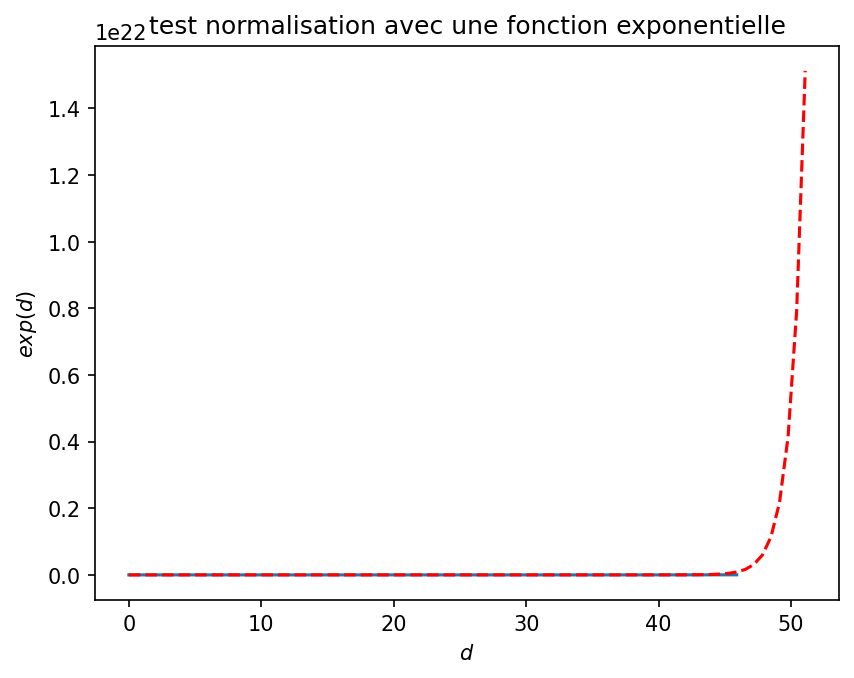

In [27]:
plt.figure(dpi=150)
plt.plot(dist[:-20],mean[:-20])
plt.xlabel('$d$')
plt.ylabel('$exp(d)$')
plt.plot(dist[:-20],np.exp(dist[:-20]),color='r',linestyle='--')
plt.title('test normalisation avec une fonction exponentielle')
plt.savefig(folderfig+'test_normalisation.pdf')
print(mean[0])

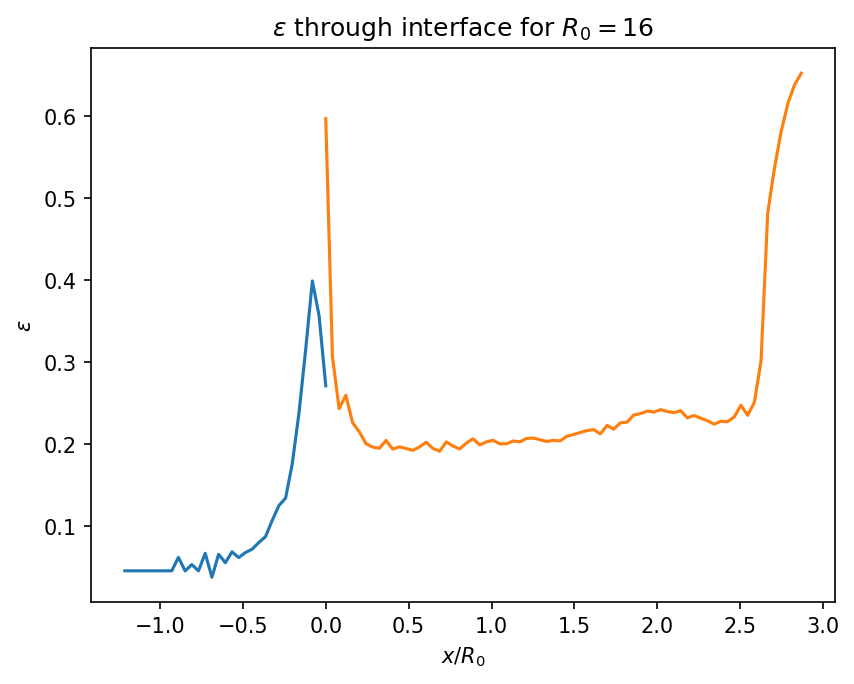

In [28]:
plt.figure(dpi=150)
plt.title(r'$\epsilon$ through interface for $R_0=16$')
plt.plot(dist*(-1)/16, meandiss_int)
plt.plot(dist/16,meandiss_ext/25)
plt.xlabel('$x/R_0$')
plt.ylabel(r'$\epsilon$')
# plt.xlim(-0.5,0.5)
plt.savefig(folderfig + 'dissipation_dump_r0=16.pdf',bbox_inches='tight')

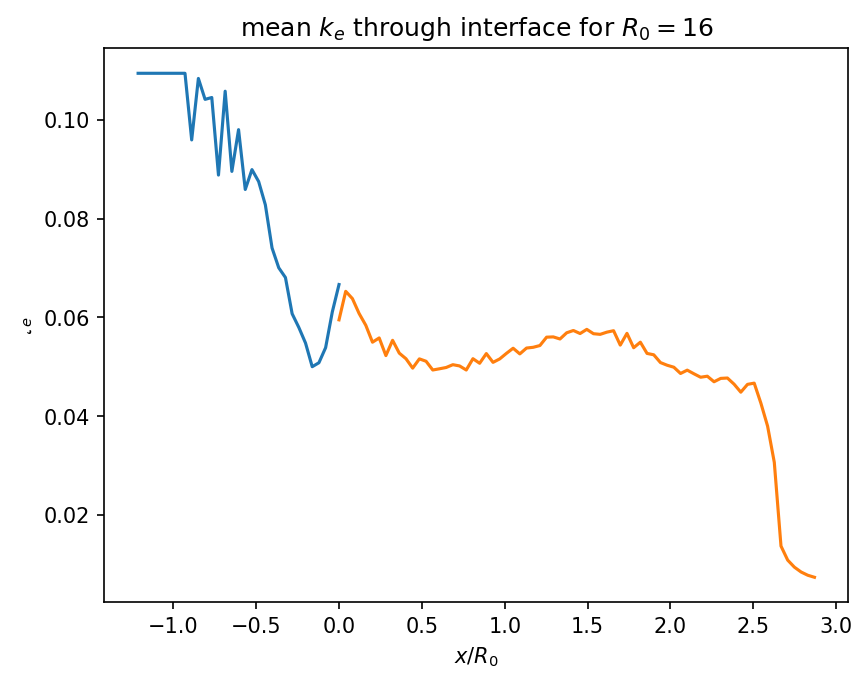

In [29]:
plt.figure(dpi=150)
plt.title('mean $k_e$ through interface for $R_0 = 16$')
plt.plot(dist*(-1)/16, meankin_int)
plt.plot(dist/16,meankin_ext/850)
# plt.xlim(-0.5,0.5)
plt.xlabel('$x/R_0$')
plt.ylabel('$\k_e$')
plt.savefig(folderfig + 'ke_dump_R0=16.pdf',bbox_inches='tight')

In [30]:
def calculate_normale(points,interf_points,region_index):
    
    normale=np.zeros([len(points),3])
    
    normale[:,:] = points[:,:] - interf_points[:,:][region_index]
    norm = np.sqrt(np.sum(normale[:,:]**2 , axis=1))
    normale /= norm[:,np.newaxis]
    
    return normale

In [31]:
def loadfiles(filename):
    '''
    Load local_stats, localstats_fluid and interface files knowing the folder direction. 
    Return datain, dataout & interf
    '''
    import warnings

    with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
        warnings.simplefilter("ignore")    
        filesdissint = glob.glob(filename + '/localstats_[!f]*')
        filesdissext = glob.glob(filename + '/localstats_fl*')
        filesinterf = glob.glob(filename + '/inter*.dat')
#         filestat = glob.glob(filename + '/stats.dat')

        data1 = np.zeros([0, 7], dtype=float)
        data2 = np.zeros([0, 6], dtype=float)
        interf = np.zeros([0, 10], dtype=float)
        stat = np.zeros([0,8], dtype=float)
        bubble = np.zeros([0,12], dtype=float)

        

        with open(filename + '/stats.dat', 'r') as f:
            stat=[]
            for line in f:
                if "t" in line:
    #         si on lit "t", on saute la ligne, ie on saute la 1er ligne
                    continue
                data=line.split()
                for i in np.arange(len(data)):
                    temp=float(data[i])
                    stat.append(temp)

    

        for file in filesdissint:
            try:
                datatemp = np.loadtxt(file, skiprows=2)
            except:
                datatemp = np.loadtxt(file, skiprows=1)
            if datatemp.shape !=(0,):
                data1 = np.vstack((data1, datatemp))

        for file in filesinterf:
            datatemp = np.loadtxt(file, skiprows=1)
            if datatemp.shape !=(0,):
                interf = np.vstack((interf, datatemp))
                
        for file in filesdissext:
            try:
                datatemp = np.loadtxt(file, skiprows=1)
            except:
                datatemp = np.loadtxt(file, skiprows=0)
            if datatemp.shape !=(0,):
                data2 = np.vstack((data2, datatemp))
        
        datatemp=np.loadtxt(filename + '/bubbles.dat',skiprows=1)
        if datatemp.shape !=(0,):
                bubble = np.vstack((bubble,datatemp))


        return data1, data2, interf, stat, bubble,

In [32]:
def compute_dist(interface_points, interface_normal, test_points):
    '''
    Compute distance, knowing the interfacial points coordinates, the interface normal 
    and the position of the inside points. 
    '''
    #Voronoi diagram
    voronoi_kdtree = cKDTree(interface_points)
    #Region of the test points
    test_point_dist, test_point_regions = voronoi_kdtree.query(test_points)
    #distance with scalar product with the normal
    distance = np.abs(np.sum((test_points-interface_points[test_point_regions])*interface_normal[test_point_regions], axis=1))
    positif=(np.sum((test_points-interface_points[test_point_regions])*interface_normal[test_point_regions], axis=1)>=0)

    return test_point_dist, test_point_regions, positif

In [34]:
dist = np.linspace(0, 8, 100)  
dist2 = np.linspace(0, 40, 500) 
dissipationint = {}
kineticint = {}
dissipationext = {}
kineticext = {}
occ_ro = {}

for fold in folds:
    
    data,data2, interf, stat, bubble = loadfiles(fold);
    #test whether the bubble broke or not. If so there are several bubbles and so 
    # bubble number can be larger than 0. 
    if int(fold.split('-')[2])==8:
        if int(fold.split('-')[3])!=800:
            continue
    print(fold)
    if 1 in data[:, 0]:
        print('break')
        print(np.max(data[:, 0]))
        continue
    

    #recenter
    pc = np.median(data[:, 1:4], axis=0)

#     point intérieurs
    maskint=(data[:,0]>-1)
    maskinterf=(interf[:,0]>-1)


#     print(bubble)
    for bulle in bubble:
        if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
            j=bulle[2]
            maskint=np.logical_and(maskint,data[:,0][:]!=j)
            maskinterf=np.logical_and(maskinterf,interf[:,0][:]!=j)

    # on recentre les points
    data[:, 1:4] = np.mod(data[:, 1:4][maskint] - pc + L/2, L) - L/2
    interf[:, 1:4] = np.mod(interf[:, 1:4][maskinterf] - pc + L/2, L) - L/2
    #compute distance
    #Voronoi diagram
    voronoi_kdtree = cKDTree(interf[:,1:4][maskinterf])
    #Region of the test points
    test_point_dist, test_point_regions = voronoi_kdtree.query(data[:,1:4][maskint])
    normale = calculate_normale(data[:,1:4][maskint],interf[:,1:4][maskinterf],test_point_regions)
    #distance with scalar product with the normal
    positif=(np.sum((data[:,1:4][maskint]-interf[:,1:4][test_point_regions])*normale, axis=1)>=0)
    maskint=np.logical_and(maskint,positif)
   
    


    #compute avg
#     sig = np.min(data[:, -1])**(1/3)/2
    weights = gaussian(test_point_dist[maskint] -dist[:, np.newaxis], sig)
    norm = np.sum(data[:, 6][maskint]*weights, axis=1)
    meandiss = np.sum(data[:, 5][maskint]*weights*data[:, 6][maskint], axis=1)/norm #mean dissip
    meankin = np.sum(data[:, 4][maskint]*weights*data[:, 6][maskint], axis=1)/norm #mean kinetic energy
    
    gamma = float(fold.split('-')[2])

    if gamma not in dissipationint:
        dissipationint[gamma] = np.zeros([3, len(dist)])
        kineticint[gamma] = np.zeros([3, len(dist)])
        occ_ro[gamma] = 0
        

    ind = dist<np.max(test_point_dist)
    dissipationint[gamma][0, :][ind] += meandiss[ind]#avg
    dissipationint[gamma][1, :][ind] += meandiss[ind]**2 #std
    dissipationint[gamma][2, :][ind] += 1#nbr

    kineticint[gamma][2, :][ind] += 1
    kineticint[gamma][0, :][ind] += meankin[ind]
    kineticint[gamma][1, :][ind] += meankin[ind]**2  
    
    occ_ro[gamma] += 1

    with open( fold +  '/dissint.pkl', 'wb') as f:
        pickle.dump(dissipationint, f)

#     points extérieurs

    data2[:, 0:3] = np.mod(data2[:, 0:3] - pc + L/2, L) - L/2
    pc=np.mean(data[:,1:4], axis=0)
    index =((data2[:,0]-pc[0])**2+(data2[:,1]-pc[1])**2+(data2[:,2]-pc[2])**2<(36*R0**2)) #6*R0
    
    #compute distance
    test_point_dist, test_point_regions = voronoi_kdtree.query(data2[:,0:3][index])
#     normale = calculate_normale(data2[:,0:3][index],interf[:,1:4][maskinterf],test_point_regions)




    #compute avg
    weights = gaussian(test_point_dist -dist2[:, np.newaxis], sig)
    norm = np.sum(data2[:, 5][index]*weights, axis=1)
    meandiss = np.sum(data2[:,4][index]*weights*data2[:, 5][index], axis=1)/norm
    meankin = np.sum(data2[:,3][index]*weights*data2[:, 5][index], axis=1)/norm
    
   
    
    if gamma not in dissipationext:
        dissipationext[gamma] = np.zeros([3, len(dist2)])
        kineticext[gamma] = np.zeros([3, len(dist2)])


    ind = dist2<np.max(test_point_dist) #
    dissipationext[gamma][0, :][ind] += meandiss[ind]#avg
    dissipationext[gamma][1, :][ind] += meandiss[ind]**2 #std
    dissipationext[gamma][2, :][ind] += 1#nbr

    kineticext[gamma][2, :][ind] += 1
    kineticext[gamma][0, :][ind] += meankin[ind]
    kineticext[gamma][1, :][ind] += meankin[ind]**2
        
    with open( fold +  '/dissext.pkl', 'wb') as f:
        pickle.dump(dissipationext, f)    
    

    
for tab in [dissipationint, kineticint]:
    for key in tab:
        tab[key][0, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1) #on divise par le nombre d'occurence pour moyenné
        tab[key][1, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
        tab[key][1, :] -= tab[key][0, :]**2
        tab[key][1, :] = np.sqrt(tab[key][1, :])

for tab in [dissipationext, kineticext]:
    for key in tab:
        tab[key][0, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
        tab[key][1, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
        tab[key][1, :] -= tab[key][0, :]**2
        tab[key][1, :] = np.sqrt(tab[key][1, :])
        

        


Re55t140-l9-16-2540-2-dump_63405


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_55336
Re55t140-l9-12-1572-dump_29055


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_46791
Re55t140-l9-8-800-3-dump_84292


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_94752


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_33343


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_102633


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_113141


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_26665


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-2-dump_60066


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_30004


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_107887


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_0
Re55t140-l9-16-2540-2-dump_73422


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_71163


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_81606


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_130206


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_73037


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_33673


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_63667


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_123528


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-5-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_84233


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_83449


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_76785


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-2-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_97379


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_60590


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-2-dump_56727


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-3-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_103483


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_78979


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_116850


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_126867


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_50539


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_34309


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_96805


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_68471


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_74911


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_76352


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_80110


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-2-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_69289


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-2-dump_66744


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_40021


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_42190


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_105260


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_65844


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_73725


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_63217


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_35547


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_110172


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_65541


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_113511


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-2-dump_76761


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_110514


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_59919


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-5-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_46699


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_41169


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_67415


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_90127


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_52698


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_37421


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_26177
Re55t140-l9-8-800-3-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_89498


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_47444


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_31682


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_106822


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-2-dump_70083


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_133545


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_100144


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_56161


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_26428


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_44917


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_80533


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_39295


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_86871


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_1


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_50071


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_52413


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-2-dump_53388


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_93466


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_71098


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_92125


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-3-dump_86166


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_36936


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_31799


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_43043


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_82407


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-4-dump_120189


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_61793


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_0


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_48665


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-5-dump_136894


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_58045


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-2-dump_78659


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_28051


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_44817


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-dump_39563


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-3-dump_88040


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_43360


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_50038


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-2-dump_57963


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-dump_36682


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-16-2540-3-dump_86788


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-12-1572-3-dump_100006


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_54287


/tmp/ipykernel_45840/3314761997.py:7: RuntimeWarning: invalid value encountered in divide
  normale /= norm[:,np.newaxis]


Re55t140-l9-8-800-dump_29925


In [35]:
lgammas = []
for key in dissipationint:
    lgammas.append(key)
lgammas = np.sort(lgammas)
print(lgammas)

#on verifie que les we sont bien égaux pour les  tailles de bulles
we1=(2*rho*eps**(2/3)*(2*8)**(5/3)/800)
we2=(2*rho*eps**(2/3)*(2*12)**(5/3)/1572)
we3=(2*rho*eps**(2/3)*(2*16)**(5/3)/2540)
print(we1,we2,we3)

[ 8. 12. 16.]
0.9989330486864284 0.9992157216548909 0.9988707857200864


In [ ]:
print(dissipationext[8.][0,:])

/tmp/ipykernel_45840/1278864938.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


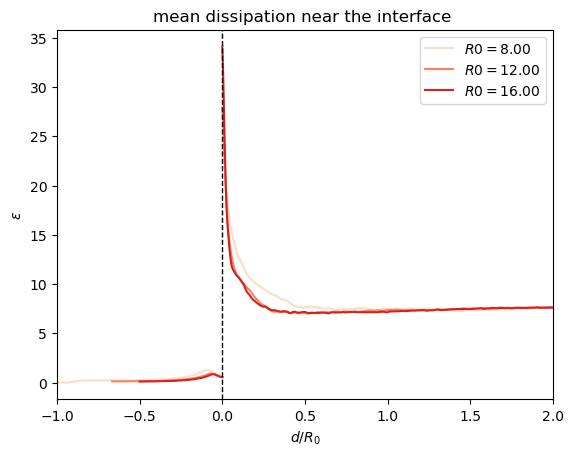

In [117]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
#     print(key, int(dissipationint[key][2, 0]))
#     print(key, int(dissipationext[key][2, 0])
    line, = plt.plot(dist2/key, dissipationext[key][0,:],color=cmap(i+1),label = f'$R0 = {key:.2f}$')
    line, = plt.plot(dist*(-1)/key, dissipationint[key][0,:],color=cmap(i+1))
    i+=2
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')
plt.xlim(-1,2)
plt.axvline(0,color='k',linestyle='--',lw=1)
# plt.axvline(-3,color='k',lw=1) #deux cellules
plt.title('mean dissipation near the interface ')
plt.savefig(folderfig + 'mean_dissipation_for_diff_sizes.pdf',bbox_inches='tight')

/tmp/ipykernel_45840/2049869582.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


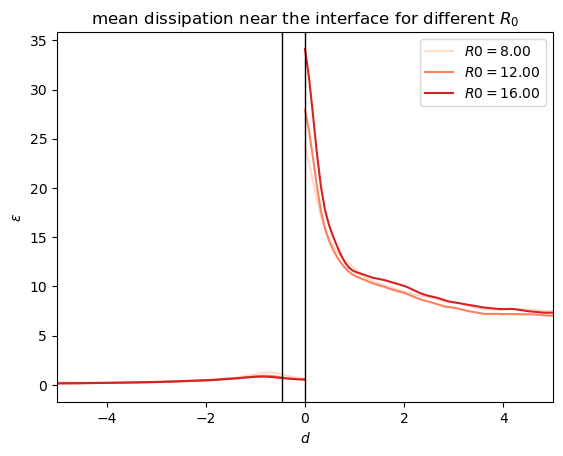

In [118]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
#     print(key, int(dissipationint[key][2, 0]))
#     print(key, int(dissipationext[key][2, 0])
    line, = plt.plot(dist2, dissipationext[key][0, :],color=cmap(i+1),label = f'$R0 = {key:.2f}$')
    line, = plt.plot(dist*(-1), dissipationint[key][0,:],color=cmap(i+1))
    i+=2
plt.legend()
plt.xlabel(r'$d$')
plt.ylabel(r'$\epsilon$')
plt.xlim(-5,5)
plt.axvline(0,color='k',lw=1)
plt.axvline(-2*dx,color='k',lw=1) #deux cellules
plt.title('mean dissipation near the interface for different $R_0$')
plt.savefig(folderfig + 'mean_dissipation_for_diff_sizes.pdf',bbox_inches='tight')

/tmp/ipykernel_45840/338339604.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


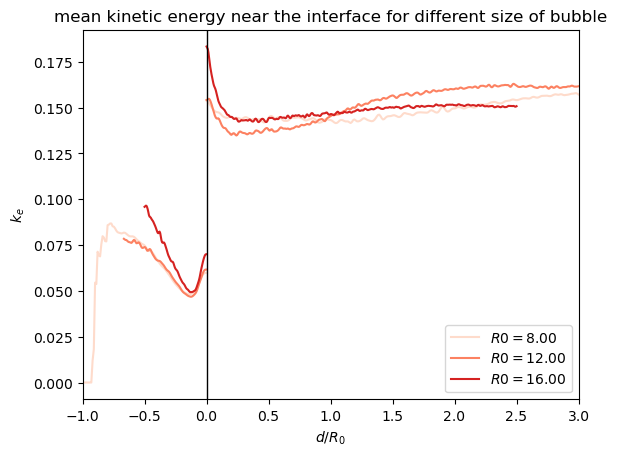

In [85]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
#     print(key, int(dissipationint[key][2, 0]))
#     print(key, int(dissipationext[key][2, 0])
    kinext=kineticext[key][0, :]/350
    line, = plt.plot(dist2/key, kinext,color=cmap(i+1),label = f'$R0 = {key:.2f}$')
    line, = plt.plot(dist*(-1)/key, kineticint[key][0,:],color=cmap(i+1))
    i+=2

plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$k_e$')
plt.xlim(-1,3)
plt.axvline(0,color='k',lw=1)
plt.title('mean kinetic energy near the interface for different size of bubble')
plt.savefig(folderfig + 'mean_kinetic_for_diff_sizes.pdf',bbox_inches='tight')


In [83]:
def expo_decr(x,a,b,cte):
    return np.exp((-1/a)*x+b)+cte
print(dissipationint[12][0,:])

[0.54806054 0.56528322 0.59103194 0.62501857 0.66557856 0.71362345
 0.770815   0.83171114 0.88281249 0.91358044 0.92223553 0.91009597
 0.88127372 0.84340345 0.80107507 0.75616985 0.71216111 0.67240107
 0.63791462 0.6074533  0.57844714 0.54923406 0.52019479 0.49322841
 0.47036321 0.45166572 0.43514642 0.41913982 0.40352097 0.38820838
 0.3727881  0.35764951 0.3435943  0.33053303 0.31785295 0.30551436
 0.29400198 0.28372637 0.27456495 0.26601309 0.2577728  0.24979491
 0.24214297 0.23493841 0.22795249 0.22104099 0.21479097 0.20959157
 0.20495732 0.20065178 0.19701616 0.19385916 0.19032547 0.18599053
 0.18099984 0.17560234 0.17028623 0.16565479 0.16203751 0.15944589
 0.15773299 0.15640126 0.15517372 0.15419506 0.15366794 0.15334809
 0.15235965 0.14989611 0.14600479 0.14220523 0.13990458 0.13889566
 0.13830826 0.13770162 0.13726889 0.1366989  0.13525337 0.13329666
 0.13171026 0.13056951 0.12965434 0.12904605 0.12844607 0.1270837
 0.12464636 0.12220255 0.12152471 0.12289132 0.12467206 0.12531

8.0 40
12.0 40
16.0 44
{8.0: array([0.14580302, 0.73558509, 0.1513187 ]), 12.0: array([0.11274937, 0.42722358, 0.11650791]), 16.0: array([0.09968725, 0.30091538, 0.09995323])}


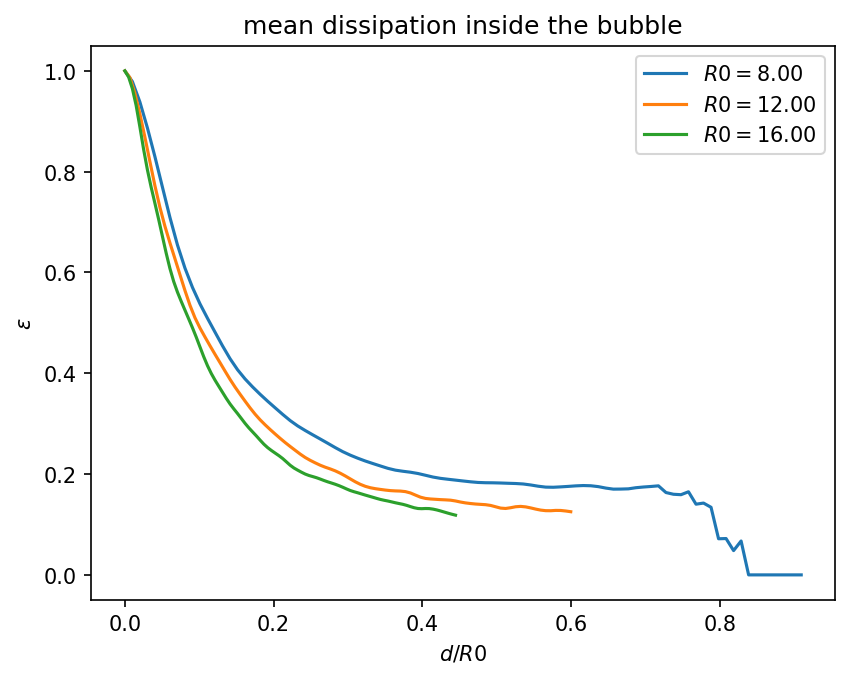

In [77]:
plt.figure(dpi=150)
opti= {}
i=0
for key in lgammas:
    if key<700:
        pass
    print(key, int(dissipationint[key][2, 0]))
    indicemax=np.argmax(dissipationint[key][0, :])
    line, = plt.plot((dist[indicemax:]-dist[indicemax])/key, dissipationint[key][0, indicemax:]/dissipationint[key][0, indicemax], label = f'$R0 = {key:.2f}$')

    popt,pcov=curve_fit(expo_decr,dist[indicemax:]/key,dissipationint[key][0,indicemax:])
    if key not in opti:
        opti[key] = np.zeros(3)
        opti[key] = popt
    i+=1
print(opti)
# plt.axvline(dx/R0, color='k', lw=1)
# plt.axvline(2*dx/R0, color='k', lw=1)
plt.legend()
plt.xlabel(r'$d/R0$')
plt.ylabel(r'$\epsilon$')
plt.title('mean dissipation inside the bubble')
plt.savefig(folderfig + 'dissipation_inside_diff_sizes.pdf',bbox_inches='tight')

8.0 40
12.0 40
16.0 44


/tmp/ipykernel_45840/3407368819.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


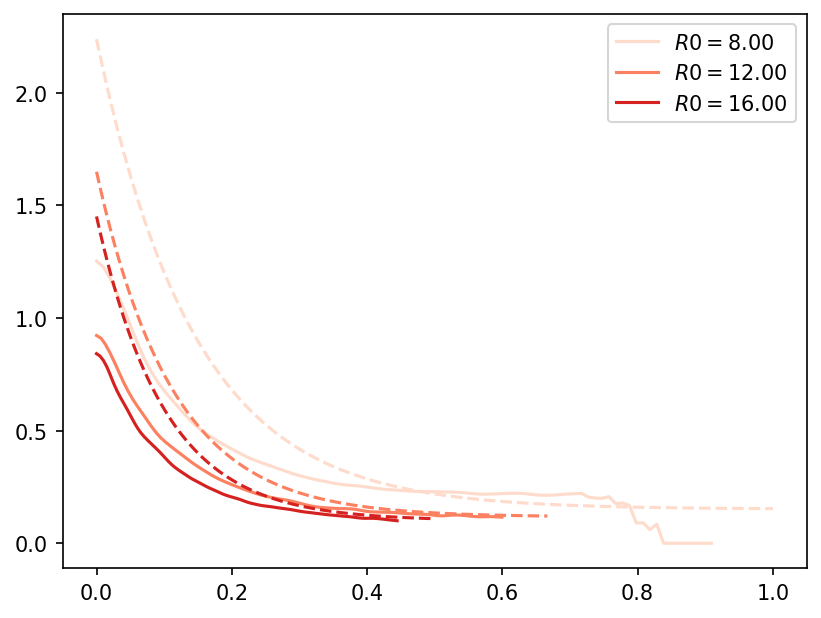

In [78]:
plt.figure(dpi=150)
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lgammas:
    if key<700:
        pass
    print(key, int(dissipationint[key][2, 0]))
    indicemax=np.argmax(dissipationint[key][0, :])
    plt.plot((dist[indicemax:]-dist[indicemax])/key, dissipationint[key][0, indicemax:], color=cmap(i+1), label = f'$R0 = {key:.2f}$')
    plt.plot(dist/key, expo_decr(dist/key,opti[key][0],opti[key][1],opti[key][2]),color=cmap(i+1),linestyle='--')
    i+=2
plt.legend()

8.0 40
12.0 40
16.0 44


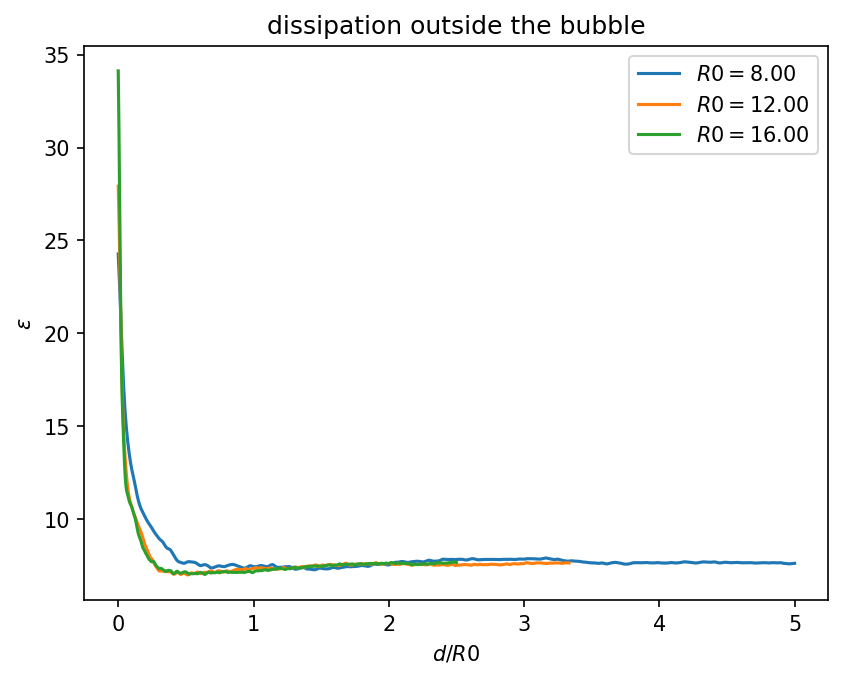

In [95]:
plt.figure(dpi=150)
i=0
opti= {}
for key in lgammas:
    if key<700:
        pass
    print(key, int(dissipationint[key][2, 0]))
    indicemax = np.argmax(dissipationext[key][0, :])
    line, = plt.plot(dist2/key, dissipationext[key][0, :], label = f'$R0 = {key:.2f}$')
    popt,pcov=curve_fit(expo_decr,dist2[indicemax:]/key,dissipationext[key][0,indicemax:])
    if key not in opti:
        opti[key] = np.zeros(3)
        opti[key] = popt
    i+=1
# plt.axvline(dx/R0, color='k', lw=1)
# plt.axvline(2*dx/R0, color='k', lw=1)
plt.legend()
# plt.xlim(0,4.5)
plt.xlabel(r'$d/R0$')
plt.ylabel(r'$\epsilon$')
plt.title('dissipation outside the bubble')
plt.savefig( folderfig + 'diss_out_R0.pdf', bbox_inches = 'tight')

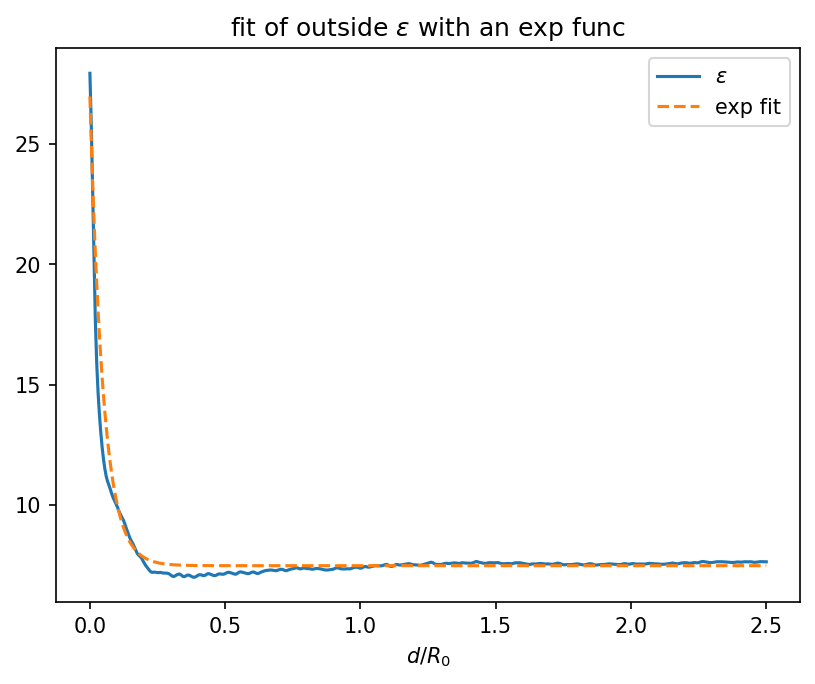

In [102]:
plt.figure(dpi=150)
# cmap = plt.cm.get_cmap('Reds', 8)
i=0
gam = 12.0

line, = plt.plot(dist2/key, dissipationext[gam][0, :], label = f'$\epsilon$')
plt.plot(dist2/key,expo_decr(dist2/key,opti[gam][0],opti[gam][1],opti[gam][2]), linestyle = '--', label='exp fit')
i+=2
plt.legend()
plt.title(r'fit of outside $\epsilon$ with an exp func')
plt.xlabel('$d/R_0$')

plt.savefig(folderfig + 'expfit_out_diss_R0.pdf', bbox_inches = 'tight')


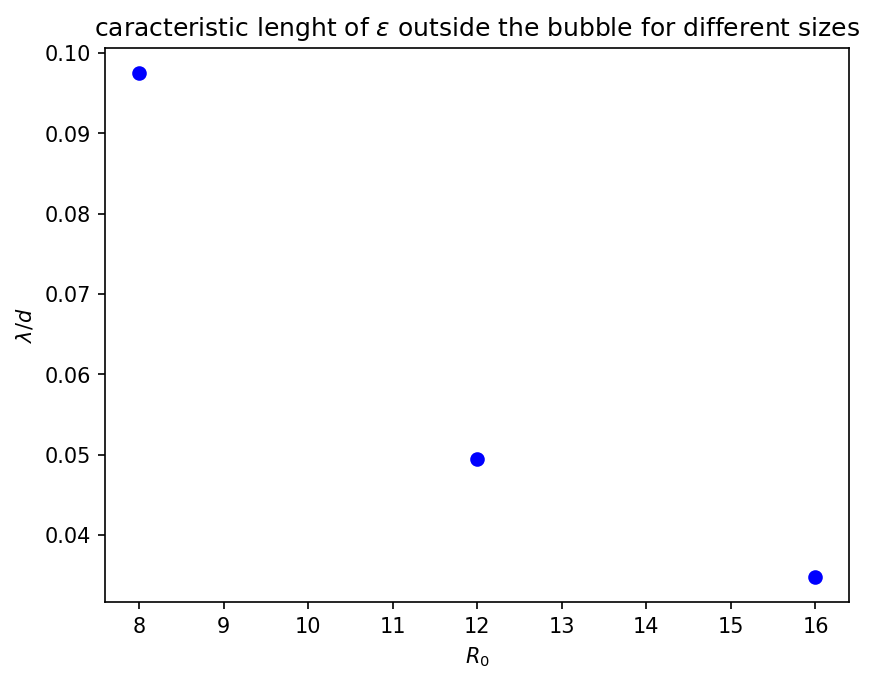

In [108]:
plt.figure(dpi=150)
for key in opti:
    plt.scatter(key, opti[key][0],color='b')
plt.xlabel('$R_0$')
plt.ylabel('$\lambda/d$')
plt.title('caracteristic lenght of $\epsilon$ outside the bubble for different sizes ')
plt.savefig(folderfig + 'diss_lenght_out_R0.pdf',bbox_inches='tight')

/tmp/ipykernel_45840/3058565720.py:9: RuntimeWarning: invalid value encountered in double_scalars
  integrale[i]=np.trapz((dissipationext[key][0,:i+1]-eps)*4*np.pi*(1+dist2[:i+1]/key)**2,dist2[:i+1]/key)/(4/3*np.pi*((x/key+1)**3-1))


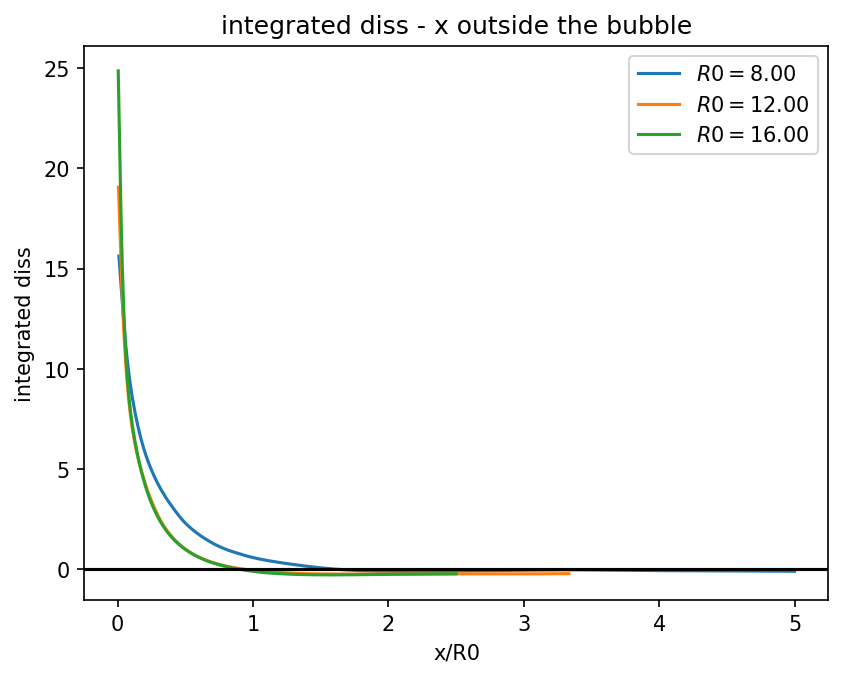

In [76]:
plt.figure(dpi=150)
integrale=np.zeros(len(dist2))

for key in lgammas:
    if key<700:
        pass
    i=0
    for x in dist2:
        integrale[i]=np.trapz((dissipationext[key][0,:i+1]-eps)*4*np.pi*(1+dist2[:i+1]/key)**2,dist2[:i+1]/key)/(4/3*np.pi*((x/key+1)**3-1))
        
        i+=1
    plt.plot(dist2/key,integrale, label = f'$R0 = {key:.2f}$')

plt.legend()
plt.xlabel('x/R0')
plt.ylabel('integrated diss')
plt.title('integrated diss - x outside the bubble')

plt.axhline(0,color='k')
# plt.xlim(0,4)
# plt.ylim(-0.2,0.2)
plt.savefig(folderfig + 'integrated_outdiss_for_diff_R0_axhline.pdf',bbox_inches='tight')
#     plt.xlim(0,1)
#     plt.ylim(-0.1,0.5)

/tmp/ipykernel_45840/3855188982.py:10: RuntimeWarning: invalid value encountered in double_scalars
  integrale[i]=np.trapz((dissipationext[key][0,:i+1]-moy)*4*np.pi*(1+dist2[:i+1]/key)**2,dist2[:i+1]/key)/(4/3*np.pi*((x/key+1)**3-1))


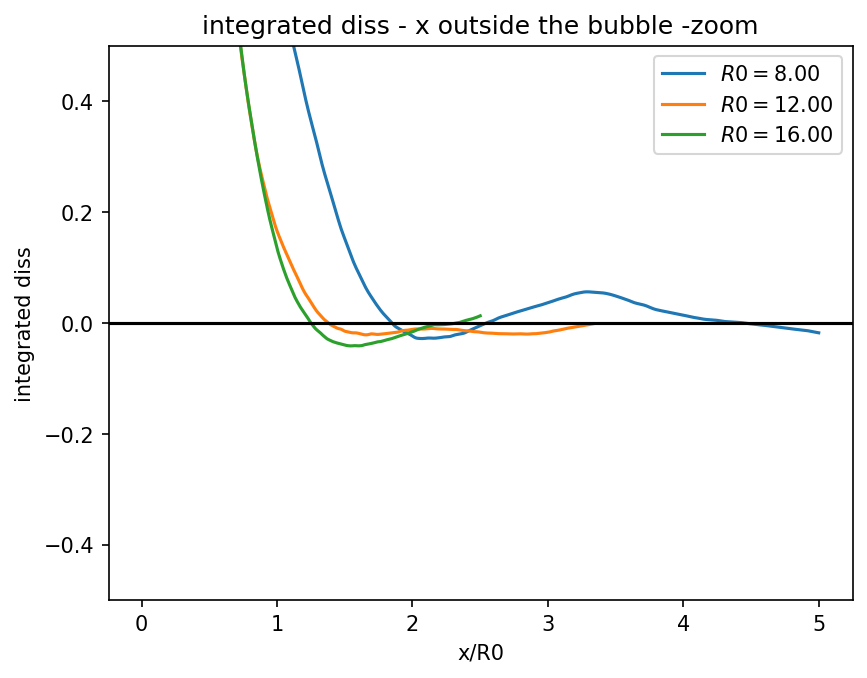

In [115]:
plt.figure(dpi=150)
integrale=np.zeros(len(dist2))

for key in lgammas:
    if key<700:
        pass
    i=0
    for x in dist2:
        moy = np.sum(dissipationext[key][0,-250:])/250
        integrale[i]=np.trapz((dissipationext[key][0,:i+1]-moy)*4*np.pi*(1+dist2[:i+1]/key)**2,dist2[:i+1]/key)/(4/3*np.pi*((x/key+1)**3-1))
        
        i+=1
    plt.plot(dist2/key,integrale, label = f'$R0 = {key:.2f}$')

plt.legend()
plt.xlabel('x/R0')
plt.ylabel('integrated diss')
plt.title('integrated diss - x outside the bubble -zoom')

plt.axhline(0,color='k')
# plt.xlim(0,4)
plt.ylim(-0.5,0.5)
plt.savefig(folderfig + 'integrated_outdiss_for_diff_R0_zoom.pdf',bbox_inches='tight')

In [ ]:
plt.plot?